# Mercari Price Suggestion Challenge

This is first of its kind and kernel only competition, and stage2 files will not be downloaded and will be available only in kernels. In this notebook, I am doing basic data exploration and reporting my findings. I will be making a simple model at the end to just as to make it complete. Val loss will be reported at the end of this notebook.

**NOTE - If you find this kernel useful, please upvote, and if you have any suggestion or if anything is not clear please comment, I will try to explain my work**

In this notebook we will extract many features and make a simple model which runs faster than **Bojan** :P I will be extracting following features - 
- **Yes/No features ** - if description present, if brand name present
- ** Category and brand encoding** - category has three levels and we will be seperating each level and then provide encoding for all three levels.
- ** SVD comp on if-idf calculated over item description** - *self explanatory*
- **SVD comp on if-itf calculated over product name** - *self explanatory*
- **item_condition_id** - use it without processing
- **shipping** - use it without processing

*Only very few features in first round of feature extraction*

*** We will train a XGB model to check how the extracted features are performing***

**PS_1:  These features are working very well, please change n_comp in SVD and change the number of iterations in XGB from 80 to 1000, you will get very high accuracies.**

**PS_2: I am learning markov models for predicting probability of author given sentence ( with history of last 3 words), I have taken a part of code from internet and I have written a probability function, but that function is faulty and I am having difficulty fixing it. If you know markov models, please contact or have a look at [notebook](https://www.kaggle.com/maheshdadhich/creative-feature-engineering-lb-0-35) **





In [1]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
import urllib        #for url stuff
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os                # for os commands
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

D:\software\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Reading in the files..

In [2]:
train_df = pd.read_csv('./input/train.tsv', sep='\t')
train_df.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


In [3]:
train_df['price'].mean()

26.737516146330442

In [4]:
train_df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [5]:
# checking test file.. 
test_df = pd.read_csv('./input/test.tsv', sep='\t')
test_df.head()
# its clear that we are supposed to predict the price, given other variables.

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


D:\software\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\software\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Time taken by above cell is 0.4977223873138428.


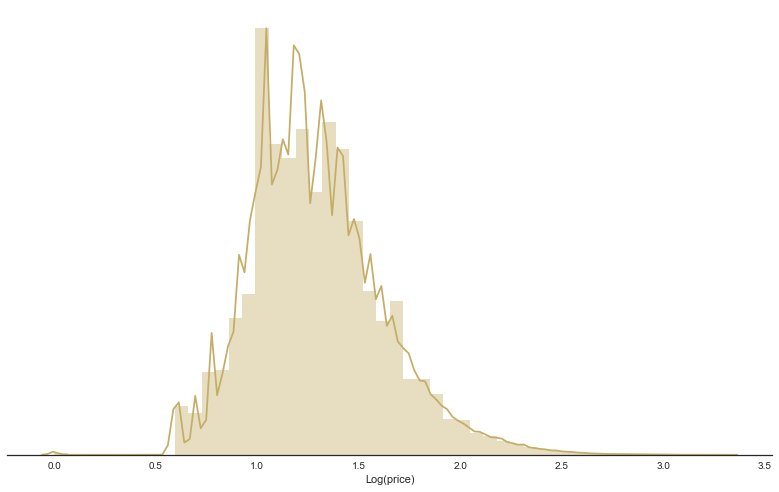

In [6]:
# Lets check the basic price histogram and see if what is the range of prices 
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log10(train_df['price'].values+1), axlabel = 'Log(price)', label = 'log(trip_duration)', bins = 50, color="y")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

In [7]:
np.log(2.7)

0.9932517730102834

** Findings ** - This is the plot of log(price), I expected that the prices variation will be there a lot, so I checked the log(price) histogram instead of normal histogram. Its clear from above plot that most of the products have price greater than 1 dollars , and highest number of products have prices between \$ 100  to \$ 1000. 

D:\software\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\software\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\software\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


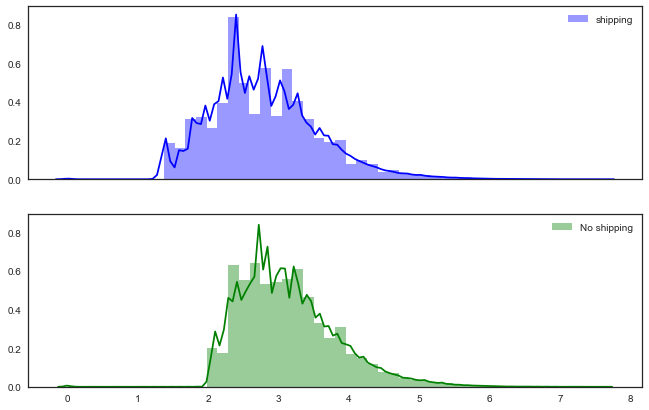

Time taken by above cell is 1.3505134582519531.


In [8]:
# Lets check if shipping has any impact on prices 
start = time.time()
fig, ax = plt.subplots(figsize=(11, 7), nrows=2, sharex=True, sharey=True)
sns.distplot(np.log(train_df.loc[train_df['shipping']==1]['price'].values+1), ax=ax[0], color='blue', label='shipping')
sns.distplot(np.log(train_df.loc[train_df['shipping']==0]['price'].values+1), ax=ax[1], color='green', label='No shipping')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

In [9]:
3/7

0.42857142857142855

**findings** - Its clear that the No shipping has slightly narrow distribution of prices and starting from 100 dollors while shipping products are starting from 10 dollars 

Time taken by above cell is 0.15775179862976074.


D:\software\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


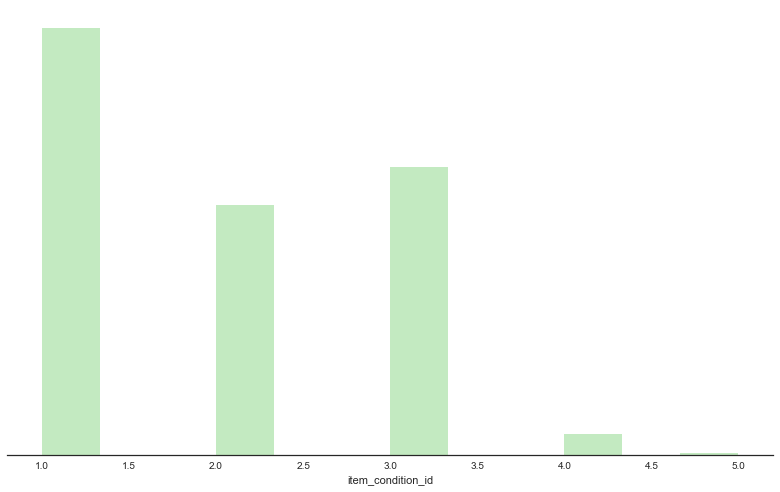

In [10]:
# Lets check the basic price histogram and see if what is the range of prices 
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(train_df['item_condition_id'], axlabel = 'item_condition_id', label = 'item_condition_id', bins = 12, color="g", kde = False)
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

# Basic feature engineering 
Lets start with features that we have mentioned in introduction in FE round 1, we will add other features but first check how these features are performing in for prediction. For finding category label, we need to first devide item category into three categories, primary, secondary and tirtiary ( I have named them _1/_2/_3 here). After that we will make a dictionary and give labels to different category and make cat labels features.

- **1. Category label features - **

In [11]:
zip([1,2],[3,4])

In [12]:
# 1. Extract 3 category related features 
def cat_split(row):
    try:
        text = row
        txt1, txt2, txt3 = text.split('/')
        return txt1, txt2, txt3
    except:
        return np.nan, np.nan, np.nan


train_df["cat_1"], train_df["cat_2"], train_df["cat_3"] = zip(*train_df.category_name.apply(lambda val: cat_split(val)))
test_df["cat_1"], test_df["cat_2"], test_df["cat_3"] = zip(*test_df.category_name.apply(lambda val: cat_split(val)))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [13]:
test_df.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,cat_1,cat_2,cat_3
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


In [14]:
# making dictionaries for different categories 
keys = train_df.cat_1.unique().tolist() + test_df.cat_1.unique().tolist()
keys = list(set(keys))
values = list(range(keys.__len__()))
cat1_dict = dict(zip(keys, values))

keys2 = train_df.cat_2.unique().tolist() + test_df.cat_2.unique().tolist()
keys2 = list(set(keys2))
values2 = list(range(keys2.__len__()))
cat2_dict = dict(zip(keys2, values2))

keys3 = train_df.cat_3.unique().tolist() + test_df.cat_3.unique().tolist()
keys3 = list(set(keys3))
values3 = list(range(keys3.__len__()))
cat3_dict = dict(zip(keys3, values3))

In [15]:
print(cat1_dict)
print(cat2_dict)

{'Women': 0, nan: 1, 'Beauty': 2, 'Men': 3, 'Electronics': 4, 'Sports & Outdoors': 5, 'Home': 6, 'Kids': 7, 'Handmade': 8, 'Other': 9, 'Vintage & Collectibles': 10}
{nan: 0, 'Glass': 1, 'Exercise': 2, 'Books': 3, 'Trading Cards': 4, 'Girls (4+)': 5, 'Weddings': 6, 'Swimwear': 7, 'Quilts': 8, 'Bath': 9, "Kids' Home Store": 10, 'Home Decor': 11, 'Home Décor': 12, 'Suits & Blazers': 13, 'Video Games & Consoles': 14, 'Nursery': 15, 'Apparel': 16, 'Girls 0-24 Mos': 17, 'Golf': 18, 'Patterns': 19, "Women's Handbags": 20, 'Storage & Organization': 21, 'Tops & Blouses': 22, 'TV, Audio & Surveillance': 23, 'Pants': 24, "Men's Accessories": 25, 'Cell Phones & Accessories': 26, 'Geekery': 27, 'Others': 28, 'Pets': 29, 'Toy': 30, 'Outdoors': 31, 'Suits': 32, 'Clothing': 33, 'Diapering': 34, 'Dresses': 35, 'Pet Supplies': 36, 'Jewelry': 37, 'Boys 2T-5T': 38, 'Music': 39, 'Fan Shop': 40, 'Art': 41, 'Makeup': 42, 'Supplies': 43, 'Candles': 44, 'Skirts': 45, 'Daily & Travel items': 46, 'Maternity': 47

In [16]:
# function to assign category label
def cat_lab(row,cat1_dict = cat1_dict, cat2_dict = cat2_dict, cat3_dict = cat3_dict):
    """function to give cat label for cat1/2/3"""
    txt1 = row['cat_1']
    txt2 = row['cat_2']
    txt3 = row['cat_3']
    return cat1_dict[txt1], cat2_dict[txt2], cat3_dict[txt3]

train_df["cat_1_label"], train_df["cat_2_label"], train_df["cat_3_lable"] = zip(*train_df.apply(lambda val: cat_lab(val), axis =1))
test_df["cat_1_label"], test_df["cat_2_label"], test_df["cat_3_lable"] = zip(*test_df.apply(lambda val: cat_lab(val), axis =1))
train_df.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,3,54,301
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,4,72,194
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0,22,424
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,6,12,717
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0,37,720
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma...",Women,Other,Other,0,91,851
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece,0,7,643
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls,5,16,244
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls,5,16,244
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...,Vintage & Collectibles,Collectibles,Doll,10,94,273


** 2. if category present -yes/no features -**

In [17]:
for i in train_df.category_name.unique():
    print(i)

Men/Tops/T-shirts
Electronics/Computers & Tablets/Components & Parts
Women/Tops & Blouses/Blouse
Home/Home Décor/Home Décor Accents
Women/Jewelry/Necklaces
Women/Other/Other
Women/Swimwear/Two-Piece
Sports & Outdoors/Apparel/Girls
Vintage & Collectibles/Collectibles/Doll
Beauty/Makeup/Face
Beauty/Fragrance/Women
Women/Dresses/Above Knee, Mini
Other/Office supplies/School Supplies
Women/Shoes/Boots
Beauty/Makeup/Makeup Sets
Beauty/Makeup/Eyes
Kids/Gear/Backpacks & Carriers
Beauty/Makeup/Makeup Palettes
Women/Tops & Blouses/Tank, Cami
Women/Athletic Apparel/Sports Bras
Electronics/Cell Phones & Accessories/Cell Phones & Smartphones
Electronics/Cell Phones & Accessories/Chargers & Cradles
Women/Tops & Blouses/T-Shirts
Men/Shoes/Athletic
Electronics/Cell Phones & Accessories/Cases, Covers & Skins
Women/Athletic Apparel/Pants, Tights, Leggings
Women/Swimwear/One-Piece
Women/Jeans/Boot Cut
Women/Underwear/Bras
Beauty/Skin Care/Face
Kids/Toys/Stuffed Animals & Plush
Women/Women's Handbags/Tot

In [18]:
def if_catname(row):
    """function to give if brand name is there or not"""
    if row == row:
        return 1
    else:
        return 0
    
train_df['if_cat'] = train_df.category_name.apply(lambda row : if_catname(row))
test_df['if_cat'] = test_df.category_name.apply(lambda row : if_catname(row))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable,if_cat
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,3,54,301,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,4,72,194,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0,22,424,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,6,12,717,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0,37,720,1


In [19]:
train_df['category_name'].iloc[122]

nan

In [20]:
pd.isnull(train_df['category_name']).sum()

6327

In [21]:
pd.isna(train_df['category_name'])

0          False
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9          False
10         False
11         False
12         False
13         False
14         False
15         False
16         False
17         False
18         False
19         False
20         False
21         False
22         False
23         False
24         False
25         False
26         False
27         False
28         False
29         False
           ...  
1482505    False
1482506    False
1482507    False
1482508    False
1482509    False
1482510    False
1482511    False
1482512    False
1482513    False
1482514    False
1482515    False
1482516    False
1482517    False
1482518    False
1482519    False
1482520    False
1482521    False
1482522    False
1482523    False
1482524    False
1482525    False
1482526    False
1482527    False
1482528    False
1482529    False
1482530    False
1482531    False
1482532    Fal

In [22]:
train_df['category_name'][(train_df['if_cat']==0)]

122        NaN
155        NaN
258        NaN
984        NaN
1185       NaN
1274       NaN
1320       NaN
1419       NaN
1491       NaN
1521       NaN
1739       NaN
2076       NaN
2195       NaN
2299       NaN
2620       NaN
2782       NaN
2838       NaN
3128       NaN
3851       NaN
3916       NaN
4194       NaN
4209       NaN
4862       NaN
5146       NaN
5163       NaN
5343       NaN
5627       NaN
6147       NaN
6348       NaN
6886       NaN
          ... 
1474220    NaN
1474923    NaN
1475747    NaN
1475847    NaN
1476120    NaN
1476662    NaN
1476668    NaN
1477396    NaN
1477873    NaN
1477900    NaN
1478078    NaN
1478247    NaN
1478454    NaN
1478898    NaN
1478923    NaN
1479117    NaN
1479167    NaN
1479245    NaN
1480098    NaN
1480224    NaN
1480241    NaN
1480798    NaN
1480949    NaN
1480995    NaN
1481003    NaN
1481249    NaN
1481750    NaN
1482252    NaN
1482443    NaN
1482473    NaN
Name: category_name, Length: 6327, dtype: object

**3. If brand name is present - yes/no features -**

In [23]:
# brand name related features 
def if_brand(row):
    """function to give if brand name is there or not"""
    if row == row:
        return 1
    else:
        return 0
    
train_df['if_brand'] = train_df.brand_name.apply(lambda row : if_brand(row))
test_df['if_brand'] = test_df.brand_name.apply(lambda row : if_brand(row))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable,if_cat,if_brand
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,3,54,301,1,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,4,72,194,1,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0,22,424,1,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,6,12,717,1,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0,37,720,1,0


** 4. Brand name label features -** 

In [24]:
# makinfg brand name dict features 
keys = train_df.brand_name.dropna().unique()
values = list(range(keys.__len__()))
brand_dict = dict(zip(keys, values))

def brand_label(row):
    """function to assign brand label"""
    try:
        return brand_dict[row]
    except:
        return np.nan

train_df['brand_label'] = train_df.brand_name.apply(lambda row: brand_label(row))
test_df['brand_label'] = test_df.brand_name.apply(lambda row: brand_label(row))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable,if_cat,if_brand,brand_label
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,3,54,301,1,0,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,4,72,194,1,1,0.0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0,22,424,1,1,1.0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,6,12,717,1,0,NaN
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0,37,720,1,0,NaN


In [25]:
brand_dict

{'Razer': 0,
 'Target': 1,
 'Acacia Swimwear': 2,
 'Soffe': 3,
 'Nike': 4,
 'Smashbox': 5,
 "Victoria's Secret": 6,
 'rue': 7,
 'Scholastic': 8,
 'UGG Australia': 9,
 'Tarte': 10,
 'Wet n Wild': 11,
 'Too Faced': 12,
 'Anthropologie': 13,
 'Torrid': 14,
 'Samsung': 15,
 'FOREVER 21': 16,
 'Air Jordan': 17,
 'Apple': 18,
 'LuLaRoe': 19,
 'Hollister': 20,
 'PINK': 21,
 'Sephora': 22,
 'Under Armour': 23,
 'Xbox': 24,
 'Kylie Cosmetics': 25,
 'The North Face': 26,
 'Brandy Melville': 27,
 'lululemon athletica': 28,
 'Michael Kors': 29,
 'Rae Dunn': 30,
 'Infantino': 31,
 "Levi's®": 32,
 'patagonia': 33,
 'Barbie': 34,
 'H&M': 35,
 'Adidas': 36,
 'Nostalgia Electrics': 37,
 'Littlest Pet Shop': 38,
 'Sea Wees': 39,
 'Motherhood Maternity': 40,
 'Melissa & Doug': 41,
 'Pokemon': 42,
 'Nintendo': 43,
 'Silver Jeans Co.': 44,
 'Spin Master': 45,
 'Gap': 46,
 'Lululemon': 47,
 'Rock Revival': 48,
 'Fossil': 49,
 'Merona': 50,
 'Boulevard Boutique': 51,
 'MARC JACOBS': 52,
 'Steve Madden': 53,


** 5. if item_description present - yes/no feature -**

In [26]:
# item description related features 
print("Description of item is not present in {}".format(train_df.loc[train_df.item_description == 'No description yet'].shape[0]))
print("while the shape of train_df is {}".format(train_df.shape[0]))

def if_description(row):
    """function to say if description is present or not"""
    if row == 'No description yet':
        a = 0
    else:
        a = 1
    return a

train_df['is_description'] = train_df.item_description.apply(lambda row : if_description(row))
test_df['is_description'] = test_df.item_description.apply(lambda row : if_description(row))
train_df.head()

Description of item is not present in 82489
while the shape of train_df is 1482535


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,cat_1_label,cat_2_label,cat_3_lable,if_cat,if_brand,brand_label,is_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,3,54,301,1,0,NaN,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,4,72,194,1,1,0.0,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0,22,424,1,1,1.0,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,6,12,717,1,0,NaN,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0,37,720,1,0,NaN,1


In [27]:
# Nulls in item description in train or test as tf-idf is not defined on nan
print(train_df.item_description.isnull().sum())
print(test_df.item_description.isnull().sum())
# lets drop these 4 items 
print(train_df.shape[0])
train_df = train_df.loc[train_df.item_description == train_df.item_description]
test_df = test_df.loc[test_df.item_description == test_df.item_description]
train_df = train_df.loc[train_df.name == train_df.name]
test_df = test_df.loc[test_df.name == test_df.name]
print(train_df.shape[0])
print("Dropped records where item description was nan")

4
0
1482535
1482531
Dropped records where item description was nan


In [28]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 693359 entries, 0 to 693358
Data columns (total 17 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
cat_1                688255 non-null object
cat_2                688255 non-null object
cat_3                688255 non-null object
cat_1_label          693359 non-null int32
cat_2_label          693359 non-null int32
cat_3_lable          693359 non-null int32
if_cat               693359 non-null int64
if_brand             693359 non-null int64
brand_label          397246 non-null float64
is_description       693359 non-null int64
dtypes: float64(1), int32(3), int64(6), object(7)
memory usage: 87.3+ MB


In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482531 entries, 0 to 1482534
Data columns (total 18 columns):
train_id             1482531 non-null int64
name                 1482531 non-null object
item_condition_id    1482531 non-null int64
category_name        1476204 non-null object
brand_name           849852 non-null object
price                1482531 non-null float64
shipping             1482531 non-null int64
item_description     1482531 non-null object
cat_1                1471815 non-null object
cat_2                1471815 non-null object
cat_3                1471815 non-null object
cat_1_label          1482531 non-null int32
cat_2_label          1482531 non-null int32
cat_3_lable          1482531 non-null int32
if_cat               1482531 non-null int64
if_brand             1482531 non-null int64
brand_label          849852 non-null float64
is_description       1482531 non-null int64
dtypes: float64(2), int32(3), int64(6), object(7)
memory usage: 197.9+ MB


** 6. SVD on tf-idf on unigrams for iten_description -**

In [30]:
# description related tf-idf features 
# I guess "No dscription present won't affact these features ... So, I am not removing them.
import time
start = time.time()
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
full_tfidf = tfidf_vec.fit_transform(train_df['item_description'].values.tolist() + test_df['item_description'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['item_description'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['item_description'].values.tolist())

n_comp = 40
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_item_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_item_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
end = time.time()
print("time taken {}".format(end - start))

time taken 184.9632544517517


In [31]:
full_tfidf

<2175890x197497 sparse matrix of type '<class 'numpy.float64'>'
	with 31331441 stored elements in Compressed Sparse Row format>

In [32]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,...,svd_item_30,svd_item_31,svd_item_32,svd_item_33,svd_item_34,svd_item_35,svd_item_36,svd_item_37,svd_item_38,svd_item_39
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3.0,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet,Men,Tops,...,0.000255,-0.000015,0.000127,-0.000024,0.000186,-0.000042,-0.000040,-0.000121,0.000072,0.000032
1,1.0,Razer BlackWidow Chroma Keyboard,3.0,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,-0.000031,0.018099,0.002724,-0.014528,-0.013106,-0.004531,-0.003340,0.003428,-0.008014,0.033745
2,2.0,AVA-VIV Blouse,1.0,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,0.033967,-0.008716,-0.006879,-0.061839,-0.037681,0.044416,-0.046339,0.006790,0.004041,-0.055924
3,3.0,Leather Horse Statues,1.0,Home/Home Décor/Home Décor Accents,NaN,35.0,1.0,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,-0.107720,-0.028389,-0.008798,0.011753,-0.040352,0.005185,-0.068707,-0.025311,-0.012976,-0.020598
4,4.0,24K GOLD plated rose,1.0,Women/Jewelry/Necklaces,NaN,44.0,0.0,Complete with certificate of authenticity,Women,Jewelry,...,-0.006031,0.001731,-0.000402,-0.004670,-0.001908,0.000945,0.000060,0.000104,-0.005579,0.003057


In [33]:
print(train_df.shape[0])
train_df = train_df.loc[train_df.item_description == train_df.item_description]
test_df = test_df.loc[test_df.item_description == test_df.item_description]
train_df = train_df.loc[train_df.name == train_df.name]
test_df = test_df.loc[test_df.name == test_df.name]
print(train_df.shape[0])
print("Dropped records where item description was nan")

1482535
1482531
Dropped records where item description was nan


**7. SVD on tf-idf of unigram of product name features -**


In [34]:
print(train_df.shape[0])
train_df = train_df.loc[train_df.item_description == train_df.item_description]
test_df = test_df.loc[test_df.item_description == test_df.item_description]
train_df = train_df.loc[train_df.name == train_df.name]
test_df = test_df.loc[test_df.name == test_df.name]
print(train_df.shape[0])
print("Dropped records where item description was nan")

1482531
1482531
Dropped records where item description was nan


In [35]:
# product name related features 

tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
full_tfidf = tfidf_vec.fit_transform(train_df['name'].values.tolist() + test_df['name'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['name'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['name'].values.tolist())

n_comp = 40
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_name_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_name_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

In [36]:
train_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'cat_1', 'cat_2', 'cat_3',
       'cat_1_label', 'cat_2_label', 'cat_3_lable', 'if_cat', 'if_brand',
       'brand_label', 'is_description', 'svd_item_0', 'svd_item_1',
       'svd_item_2', 'svd_item_3', 'svd_item_4', 'svd_item_5', 'svd_item_6',
       'svd_item_7', 'svd_item_8', 'svd_item_9', 'svd_item_10', 'svd_item_11',
       'svd_item_12', 'svd_item_13', 'svd_item_14', 'svd_item_15',
       'svd_item_16', 'svd_item_17', 'svd_item_18', 'svd_item_19',
       'svd_item_20', 'svd_item_21', 'svd_item_22', 'svd_item_23',
       'svd_item_24', 'svd_item_25', 'svd_item_26', 'svd_item_27',
       'svd_item_28', 'svd_item_29', 'svd_item_30', 'svd_item_31',
       'svd_item_32', 'svd_item_33', 'svd_item_34', 'svd_item_35',
       'svd_item_36', 'svd_item_37', 'svd_item_38', 'svd_item_39',
       'svd_name_0', 'svd_name_1', 'svd_name_2', 'svd_name_3', 'svd_name_4',
  

In [37]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,...,svd_name_30,svd_name_31,svd_name_32,svd_name_33,svd_name_34,svd_name_35,svd_name_36,svd_name_37,svd_name_38,svd_name_39
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3.0,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet,Men,Tops,...,0.015592,-0.007353,-0.003108,-0.002799,-0.005858,0.007144,-0.006275,0.003096,0.001375,0.001412
1,1.0,Razer BlackWidow Chroma Keyboard,3.0,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,0.000106,0.000098,0.000007,0.000091,-0.000014,-0.000061,-0.000008,0.000355,-0.000098,0.000309
2,2.0,AVA-VIV Blouse,1.0,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,0.009626,0.007930,0.000295,0.002682,-0.000198,0.002589,-0.001019,0.001944,-0.001403,-0.002146
3,3.0,Leather Horse Statues,1.0,Home/Home Décor/Home Décor Accents,NaN,35.0,1.0,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,-0.010684,0.011535,-0.003303,-0.007475,0.000256,-0.007369,-0.003243,0.000786,0.000480,-0.002448
4,4.0,24K GOLD plated rose,1.0,Women/Jewelry/Necklaces,NaN,44.0,0.0,Complete with certificate of authenticity,Women,Jewelry,...,0.042675,0.038827,0.013679,0.009979,-0.003023,-0.033871,-0.016090,0.061190,0.006189,-0.047622


In [38]:
# test check for dimensions before model 
print("Train should have one columns more than test")
print(train_df.shape[1])
print(test_df.shape[1])
print("perfect The data is fine")

Train should have one columns more than test
98
97
perfect The data is fine


 # XGboost regressor ...
 Now we have 49 features which could be used in price prediction and let's use them and see how they are performing 

In [39]:
# XGboost regressor ...
# replace all nan with -1 
print(train_df.isnull().sum())
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)
print(train_df.isnull().sum())

train_id                  4
name                      4
item_condition_id         4
category_name          6331
brand_name           632683
price                     4
shipping                  4
item_description          4
cat_1                 10720
cat_2                 10720
cat_3                 10720
cat_1_label               4
cat_2_label               4
cat_3_lable               4
if_cat                    4
if_brand                  4
brand_label          632683
is_description            4
svd_item_0                8
svd_item_1                8
svd_item_2                8
svd_item_3                8
svd_item_4                8
svd_item_5                8
svd_item_6                8
svd_item_7                8
svd_item_8                8
svd_item_9                8
svd_item_10               8
svd_item_11               8
                      ...  
svd_name_10               4
svd_name_11               4
svd_name_12               4
svd_name_13               4
svd_name_14         

In [40]:
train = train_df.copy()
test = test_df.copy()
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")
do_not_use_for_training = ['cat_1','test_id','cat_2','cat_3','train_id','name', 'category_name', 'brand_name', 'price', 'item_description']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

Difference of features in train and test are ['price' 'train_id']

We will be using following features for training ['item_condition_id', 'shipping', 'cat_1_label', 'cat_2_label', 'cat_3_lable', 'if_cat', 'if_brand', 'brand_label', 'is_description', 'svd_item_0', 'svd_item_1', 'svd_item_2', 'svd_item_3', 'svd_item_4', 'svd_item_5', 'svd_item_6', 'svd_item_7', 'svd_item_8', 'svd_item_9', 'svd_item_10', 'svd_item_11', 'svd_item_12', 'svd_item_13', 'svd_item_14', 'svd_item_15', 'svd_item_16', 'svd_item_17', 'svd_item_18', 'svd_item_19', 'svd_item_20', 'svd_item_21', 'svd_item_22', 'svd_item_23', 'svd_item_24', 'svd_item_25', 'svd_item_26', 'svd_item_27', 'svd_item_28', 'svd_item_29', 'svd_item_30', 'svd_item_31', 'svd_item_32', 'svd_item_33', 'svd_item_34', 'svd_item_35', 'svd_item_36', 'svd_item_37', 'svd_item_38', 'svd_item_39', 'svd_name_0', 'svd_name_1', 'svd_name_2', 'svd_name_3', 'svd_name_4', 'svd_name_5', 'svd_name_6', 'svd_name_7', 'svd_name_8', 'svd_name_9', 'svd_name_10', 'svd_

In [41]:
y = np.log(train['price'].values + 1)

In [42]:
from sklearn.model_selection import train_test_split
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

start = time.time()
xgb_par = {'min_child_weight': 20, 'eta': 0.05, 'colsample_bytree': 0.5, 'max_depth': 15,
            'subsample': 0.9, 'lambda': 2.0, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model_1 = xgb.train(xgb_par, dtrain, 80, watchlist, early_stopping_rounds=20, maximize=False, verbose_eval=20)
print('Modeling RMSLE %.5f' % model_1.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))

[0]	train-rmse:2.4678	valid-rmse:2.46846
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[20]	train-rmse:1.04501	valid-rmse:1.05374
[40]	train-rmse:0.625941	valid-rmse:0.657615
[60]	train-rmse:0.523737	valid-rmse:0.576317
[79]	train-rmse:0.492295	valid-rmse:0.560509
Modeling RMSLE 0.56051
Time taken in training is 741.9578881263733.


In [43]:
start = time.time()
yvalid = model_1.predict(dvalid)
ytest = model_1.predict(dtest)
end = time.time()
print("Time taken in prediction is {}.".format(end - start))

Time taken in prediction is 7.618578195571899.


D:\software\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\software\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\software\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


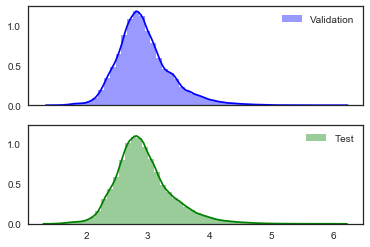

Time taken by above cell is 1.6134634017944336.


In [44]:
# Lets check how the distribution of test and vaidation set looks like ...
start = time.time()
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(yvalid, ax=ax[0], color='blue', label='Validation')
sns.distplot(ytest, ax=ax[1], color='green', label='Test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

In [45]:
start = time.time()
if test.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test['price'] = np.exp(ytest) - 1
test[['test_id', 'price']].to_csv('mahesh_xgb_submission_mercari.csv', index=False)
end = time.time()
print("Time taken in training is {}.".format(end - start))

Test shape OK.
Time taken in training is 3.4173994064331055.


**Sleep time zzzzz......**
# Upvote if you find this analysis useful... Thanks (y)